# Link between free space and 3-points efficiency

After modelling both model of space occupation and comparing them, we focus on the correlation between space occupation and 3-point performance. To do so, we browse all the games we have, we track when there are 3-point shots and then memorize the evolution of pressure on the shooter 3 seconds before he shots. The algorithm is not presented here, but is available as a python file : track_shoot.py.

Here we extract the informations we want from the data we collected. 

## Data import
-----

The shots are memorized in python dictionnary called Shots (too big to be on the repository). It is composed of nine keys :
* D_CLOSEST_DEF : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element is the evolution of the shooter's *free space* ($\delta_{space}^*$ distance to the closest defender) 3 seconds before the shot. 
* T_CLOSEST_DEF : It the same but *free space* is calculated as the time (in second) needed by the closest defender to join the position of the shooter ($\delta_{time}^*$). 
* TIME_TO_SHOOT : a list of list. Each list has two elements : the first one for the result of the shot and the second one corresponds to the time between the reception of the ball and the shot. It is negative : -2 means that the shooter kept the ball 2 seconds before shooting.
* TIME_ABSCISSE : a list of list. Each list corresponds to a shot and has two elements. The first one is 0 or 1 : if it is 1 it means that the shot was a success and if it is 0 the shot was missed. The second element corresponds to time values linked to pressure evolution.
* WHO_SHOT : a list which contains shooters' ID.
* POSITION_SHOT : a list which contains position of the player at the release.
* BALL_TRAJECTORIES : a list of list which contains for each shots ball's trajectory.
* TIME_SHOTS : a list of list which contains the release time in the following format : 5-quarter,time in seconds
* MATCH_ID : a list containing matches ID


In [1]:
import pickle
dico=pickle.load(open('data/Shots_663','rb'))
print(dico.keys())
print('number of shots :', len(dico['D_CLOSEST_DEF']))

dict_keys(['D_CLOSEST_DEF', 'T_CLOSEST_DEF', 'TIME_TO_SHOOT', 'TIME_ABSCISSE', 'WHO_SHOT', 'POSTION_SHOT', 'BALL_TRAJECTORIES', 'TIME_SHOTS', 'MATCH_ID'])
number of shots : 28383


In [2]:
dico['POSTION_SHOT'][2]

[12.77934, 47.70005]

## *Free space* evolution before a 3-point shot
------

### Global evolution

First we compute a function that restructured the data. Then we compute a function to plot the evolution of *free space* averaged on all the shots. Let's note that we round the values of time with a precision of 0.01 second. Yet the precision of position data is only 0.04 seconds. 

Let's note that we delet some shots because the values of time are wrong : the clock stops but the evolution continue to be captured therefore, if we don't do that, we have false values for a certain value of time.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def restructure_data(data):
    
    ### getting the data ###
    D_CLOSEST_PLAYER=data['D_CLOSEST_DEF']
    T_CLOSEST_PLAYER=data['T_CLOSEST_DEF']
    TIME=data['TIME_ABSCISSE']
    TIME_TO_SHOOT=data['TIME_TO_SHOOT']
    WHO_SHOT=data['WHO_SHOT']
    POSITION_SHOT=data['POSTION_SHOT']
    BALL_TRAJECTORIES=data['BALL_TRAJECTORIES']
    TIME_SHOTS=data['TIME_SHOTS']
    MATCH_ID=data['MATCH_ID']
    
    ### only the second column because the first one contains if it is a succes or a miss ###
    D_CLOSEST_PLAYER_bis=[]
    T_CLOSEST_PLAYER_bis=[]
    TIME_bis=[]
    TIME_TO_SHOOT_bis=[]
    WHO_SHOT_bis=[]
    X_SHOT=[]
    Y_SHOT=[]
    X_BALL=[]
    Y_BALL=[]
    Z_BALL=[]
    QUARTER=[]
    CLOCK=[]
    MATCH_ID_bis=[]
    SUCCESS=[]
    SHOT_ID=[]
    nb_catch_and_shoot=0
    nb_pull_up=0
    nb_success=0
    nb_missed=0
    nb_cns_success=0
    nb_cns_missed=0
    nb_pull_up_success=0
    nb_pull_up_missed=0
    for k in range(len(D_CLOSEST_PLAYER)):
        unique,count=np.unique(np.array(TIME[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if D_CLOSEST_PLAYER[k][0]==0:
                nb_missed+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_missed+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_missed+=1
            else :
                nb_success+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_success+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_success+=1
            D_CLOSEST_PLAYER_bis.append(D_CLOSEST_PLAYER[k][1])
            T_CLOSEST_PLAYER_bis.append(T_CLOSEST_PLAYER[k][1])
            TIME_bis.append(np.array(TIME[k][1]).round(2)) # round to 0.01 second
            TIME_TO_SHOOT_bis.append([TIME_TO_SHOOT[k][1]]*len(TIME[k][1]))
            SUCCESS.append([TIME_TO_SHOOT[k][0]]*len(TIME[k][1]))
            WHO_SHOT_bis.append([WHO_SHOT[k]]*len(TIME[k][1]))
            X_SHOT.append([POSITION_SHOT[k][0]]*len(TIME[k][1]))
            Y_SHOT.append([POSITION_SHOT[k][1]]*len(TIME[k][1]))
            X_BALL.append(np.array(BALL_TRAJECTORIES[k][0]))
            Y_BALL.append(np.array(BALL_TRAJECTORIES[k][1]))
            Z_BALL.append(np.array(BALL_TRAJECTORIES[k][2]))
            QUARTER.append([5-TIME_SHOTS[k][0]]*len(TIME[k][1]))
            CLOCK.append([TIME_SHOTS[k][1]]*len(TIME[k][1]))
            MATCH_ID_bis.append([MATCH_ID[k]]*len(TIME[k][1]))
            SHOT_ID.append([k]*len(TIME[k][1]))
    
    print('number of valid shot:',len(D_CLOSEST_PLAYER_bis))
    print('number of success :',nb_success)
    print('number of miss :',nb_missed)
    print('percentage of success:',nb_success/(nb_success+nb_missed)*100)
    print('percentage of catch-and-shoot shots :',nb_catch_and_shoot/(nb_pull_up+nb_catch_and_shoot)*100)
    print('percentage of catch-and-shoot success:',nb_cns_success/(nb_cns_missed+nb_cns_success)*100)
    print('percentage of pull-up success:',nb_pull_up_success/(nb_pull_up_missed+nb_pull_up_success)*100)
    
    ### we concatenate all the data
    TIME_bis=np.concatenate(np.array(TIME_bis)) 
    D_CLOSEST_PLAYER_bis=np.concatenate(np.array(D_CLOSEST_PLAYER_bis))
    T_CLOSEST_PLAYER_bis=np.concatenate(np.array(T_CLOSEST_PLAYER_bis))
    TIME_TO_SHOOT_bis=np.concatenate(np.array(TIME_TO_SHOOT_bis))
    SUCCESS=np.concatenate(np.array(SUCCESS))
    WHO_SHOT_bis=np.concatenate(np.array(WHO_SHOT_bis))
    X_SHOT=np.concatenate(np.array(X_SHOT))
    Y_SHOT=np.concatenate(np.array(Y_SHOT))
    X_BALL=np.concatenate(np.array(X_BALL))
    Y_BALL=np.concatenate(np.array(Y_BALL))
    Z_BALL=np.concatenate(np.array(Z_BALL))
    QUARTER=np.concatenate(np.array(QUARTER))
    CLOCK=np.concatenate(np.array(CLOCK))
    MATCH_ID_bis=np.concatenate(np.array(MATCH_ID_bis))
    SHOT_ID=np.concatenate(np.array(SHOT_ID))
    
    ### put the data into a dataframe ###
    df=pd.DataFrame({'D':D_CLOSEST_PLAYER_bis,'T':T_CLOSEST_PLAYER_bis,'Time':TIME_bis,'Time_to_shoot':TIME_TO_SHOOT_bis,'Shot result':SUCCESS,'player_id':WHO_SHOT_bis,'x_ball':X_BALL,'y_ball':Y_BALL,'z_ball':Z_BALL,'x_shooter':X_SHOT,'y_shooter':Y_SHOT,'quarter':QUARTER,'clock':CLOCK,'Match_id':MATCH_ID_bis,'shot_id':SHOT_ID})
    
    ## only evolution between 3.2 seconds before shot and 0.8 second after. (It is because there are some errors in the data) ##
    df=df.query('Time>-3.2 and Time<0.8').copy()
    
    return(df)

def averaged_evolution(df,sd=None,hue=None,palette=['blue'],style=None,fontsize='medium',size=None):
    
    ## rename columns to have good labels ##
    df2=df.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize=fontsize)
    plt.show()
    plt.clf()

number of valid shot: 27477
number of success : 9546
number of miss : 17931
percentage of success: 34.74178403755869
percentage of catch-and-shoot shots : 78.7531389889726
percentage of catch-and-shoot success: 35.902768150099355
percentage of pull-up success: 30.438506337786915


No handles with labels found to put in legend.


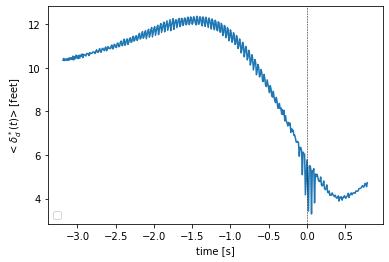

No handles with labels found to put in legend.


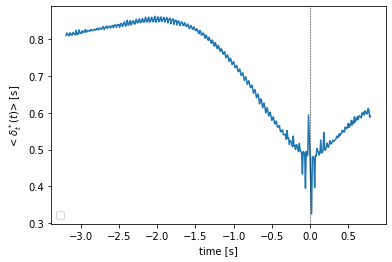

<Figure size 432x288 with 0 Axes>

In [5]:
df=restructure_data(dico)
averaged_evolution(df)

We see that there is some noise. To calculate the plot sns.lineplot take each value of time and make a mean over all the pressure value associated. If we count the number of pressure values per time value we can see that there isn't an equilibrium as there are more of multiple of 0.04 :

In [6]:
print('count',df.groupby('Time').count())

count            D      T  Time_to_shoot  Shot result  player_id  x_ball  y_ball  \
Time                                                                         
-3.19   3487   3487           3487         3487       3487    3487    3487   
-3.18   2949   2949           2949         2949       2949    2949    2949   
-3.17   4209   4209           4209         4209       4209    4209    4209   
-3.16  14848  14848          14848        14848      14848   14848   14848   
-3.15   3762   3762           3762         3762       3762    3762    3762   
...      ...    ...            ...          ...        ...     ...     ...   
 0.75   2452   2452           2452         2452       2452    2452    2452   
 0.76  19854  19854          19854        19854      19854   19854   19854   
 0.77   3774   3774           3774         3774       3774    3774    3774   
 0.78    532    532            532          532        532     532     532   
 0.79    172    172            172          172        172

Our aim is to make mean for each value of time over the 26325 shots. To do so, we will aggregate values around multiple of 0.04 seconds with the following function :

In [7]:
def aggregating_04(row):
    number=row['Time']
    q=number//0.04
    if abs(round((q*0.04-number),2))<=0.02:
        return(q*0.04)
    else :
        return((q+1)*0.04)

No handles with labels found to put in legend.


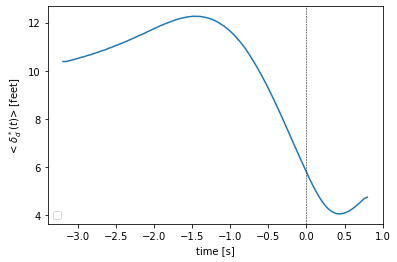

No handles with labels found to put in legend.


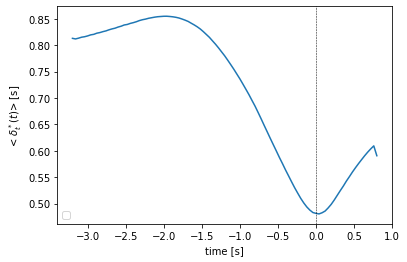

<Figure size 432x288 with 0 Axes>

In [8]:
df['Time']=df.apply(aggregating_04,axis=1)
averaged_evolution(df)

The result is better here. Now let's see if we plot the standard deviation :

No handles with labels found to put in legend.


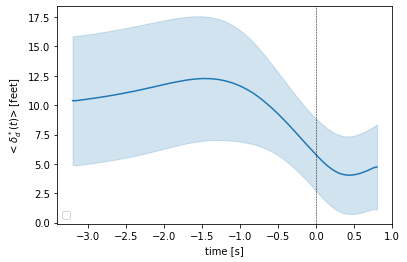

No handles with labels found to put in legend.


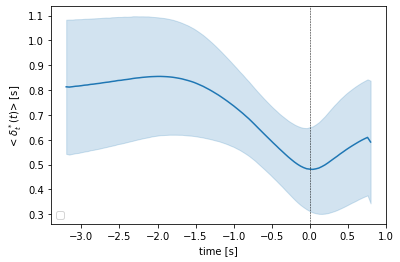

<Figure size 432x288 with 0 Axes>

In [9]:
averaged_evolution(df,sd='sd')

### Different types of shots

We distinguish two types of shots :
* catch-and-shoot shot : when a player immediately shot after receiving the ball (2 seconds after)
* pull-up shot : when a player shot after dribbling

In fact some shots can be in neither category : wait more than two seconds without dribbling. But we admit that this is only a small part of shots. Therefore to distinguish both types we look at the value TIME_TO_SHOOT.

We found that there were 78% of catch-and-shoot shots. Yet our games are from 2013 to 2016, according to https://www.thespax.com/nba/three-point-shooting-part-i-the-dying-catch-and-shoot-shot/, there were about 75% of catch-and-shoot shots. Our value is closed to the reality.

In [6]:
def shot_type(row):
    if row['Time_to_shoot']>-2:
        return('catch-and-shoot 3P')
    else :
        return('pull-up 3P')

In [7]:
df['Shot type']=df.apply(shot_type,axis=1)

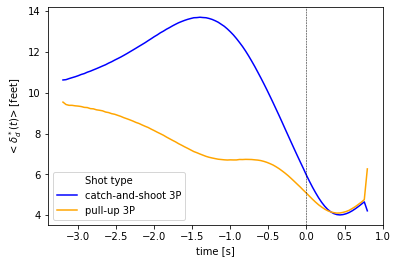

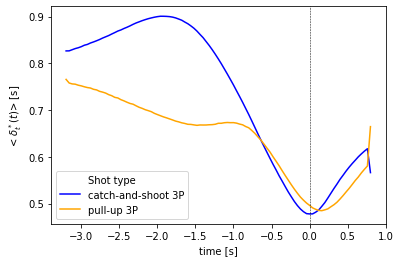

<Figure size 432x288 with 0 Axes>

In [12]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type')

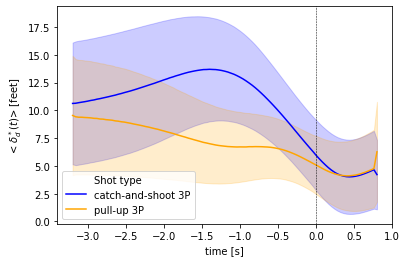

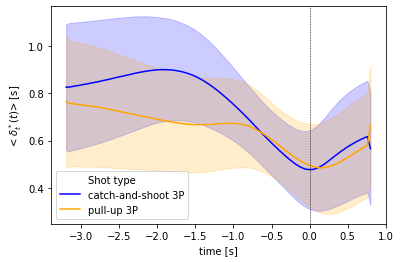

<Figure size 432x288 with 0 Axes>

In [13]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',sd='sd')

### Difference between success and miss

We want to know if the pressure exerced on a player has an influence on his 3-point performance.

In [14]:
def shot_result(row):
    if row['Shot result']==0:
        return('miss')
    else :
        return('success')

In [15]:
df['Shot result']=df.apply(shot_result,axis=1)

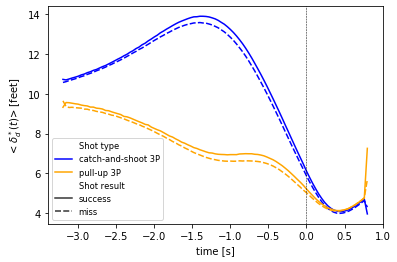

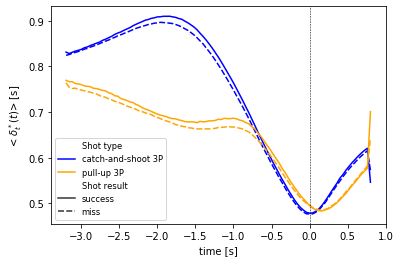

<Figure size 432x288 with 0 Axes>

In [16]:
averaged_evolution(df,palette=['blue','orange'],hue='Shot type',style='Shot result',fontsize='small')

### Curry's case

No handles with labels found to put in legend.


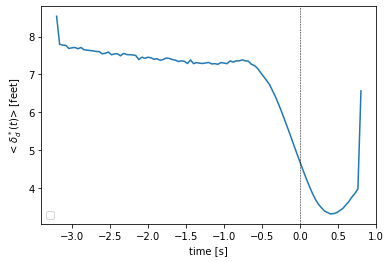

No handles with labels found to put in legend.


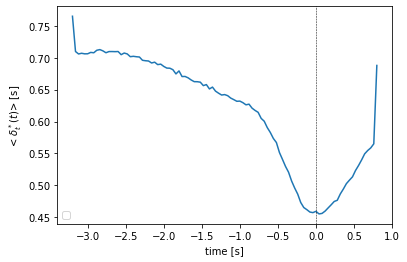

<Figure size 432x288 with 0 Axes>

In [17]:
df_curry=df.query('player_id==201939').copy()
averaged_evolution(df_curry)

No handles with labels found to put in legend.


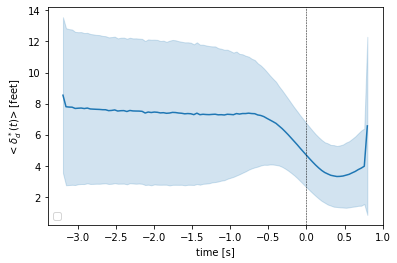

No handles with labels found to put in legend.


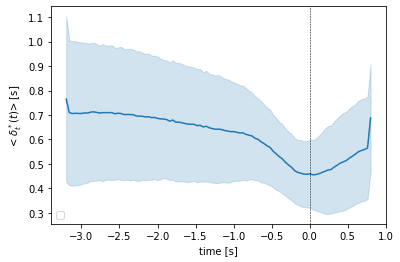

<Figure size 432x288 with 0 Axes>

In [18]:
averaged_evolution(df_curry,sd='sd')

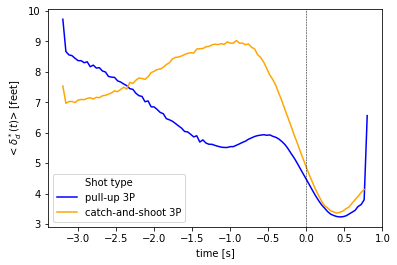

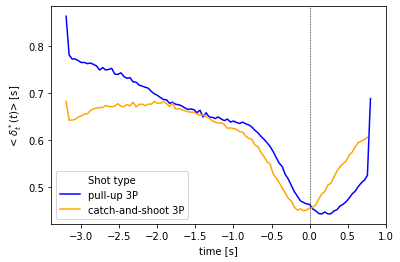

<Figure size 432x288 with 0 Axes>

In [19]:
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type')

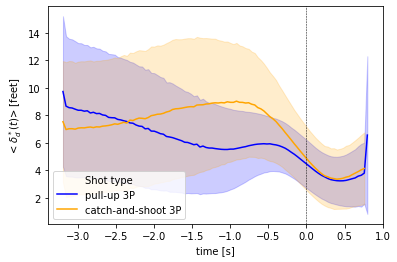

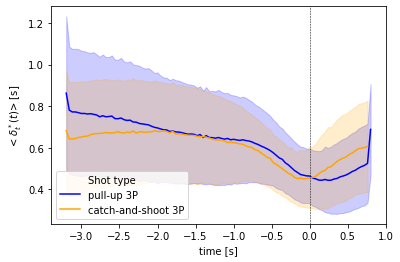

<Figure size 432x288 with 0 Axes>

In [20]:
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',sd='sd')

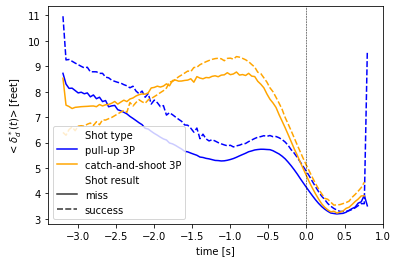

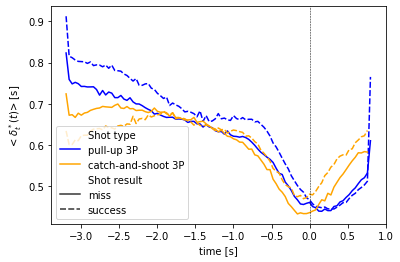

<Figure size 432x288 with 0 Axes>

In [21]:
#df_curry['Shot result']=df_curry.apply(shot_result,axis=1)
averaged_evolution(df_curry,palette=['blue','orange'],hue='Shot type',style='Shot result')

### Compare Curry to global behaviour

In [42]:
def averaged_evolution_two_df(df,df_curry,sd=None,hue=None,palette=['blue'],style=None,size=None):
    
    ## rename columns to have good labels ##
    df2=pd.concat([df,df_curry],ignore_index=True)
    players=['all' for k in range(len(df))]+['Curry' for k in range(len(df_curry))]
    df2['Player']=players
    df2=df2.rename(columns={"Time": "time [s]",'D':r'$<\delta_{d}^*(t)$> [feet]','T':r'$<\delta_{t}^*(t)$> [s]'})
    
    ### plot ###
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{d}^*(t)$> [feet]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    plt.show()
    plt.clf()
   
    ax = sns.lineplot(x="time [s]", y=r'$<\delta_{t}^*(t)$> [s]', data=df2,palette=palette,ci=sd,hue=hue,style=style,size=size)
    plt.axvline(0, color='black',linestyle="dashed",lw=0.5)
    plt.legend(loc='lower left',fontsize='small')
    #plt.savefig('Comparison_curry_t',dpi=72)
    plt.show()
    plt.clf()

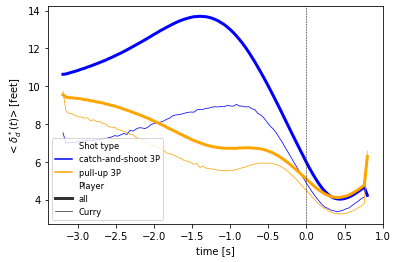

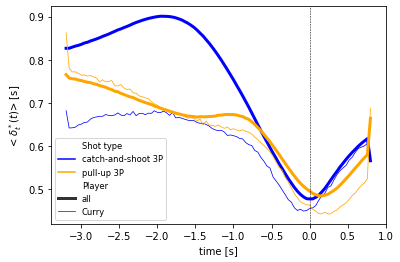

<Figure size 432x288 with 0 Axes>

In [43]:
averaged_evolution_two_df(df,df_curry,sd=None,hue='Shot type',palette=['blue','orange'],style=None,size='Player')

## Curry superimposed shots

(0, 2)

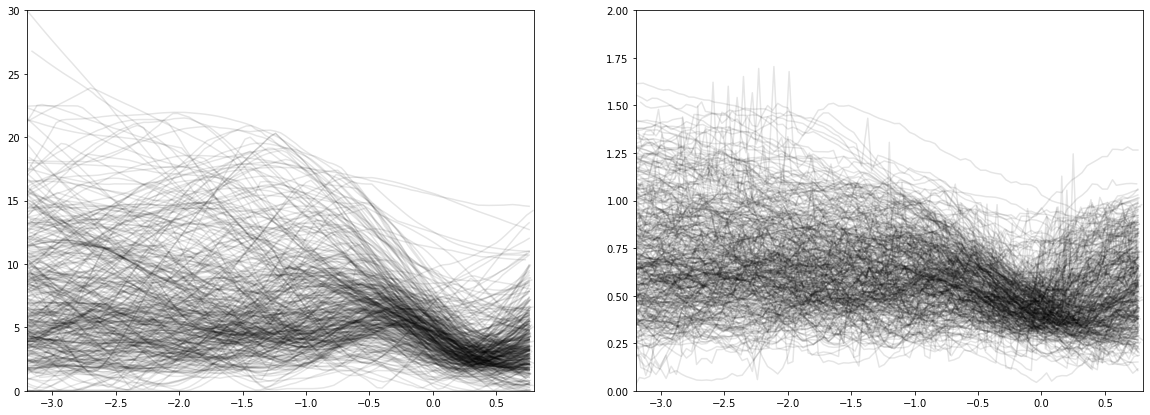

In [11]:
def shot_type_bis(row):
    if row['Time_to_shoot'][0]>-1:
        return('catch-and-shoot 3P')
    else :
        return('pull-up 3P')

df_shots['Shot_type']=df_shots.apply(shot_type_bis,axis=1)
df_curry_bis=df_shots.query('player_id==201939').copy()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))
k=0
for row in df_curry_bis.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'k-',alpha=0.1)
    ax2.plot(Time,T,'k-',alpha=0.1)
    k+=1
    
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

(0, 30)

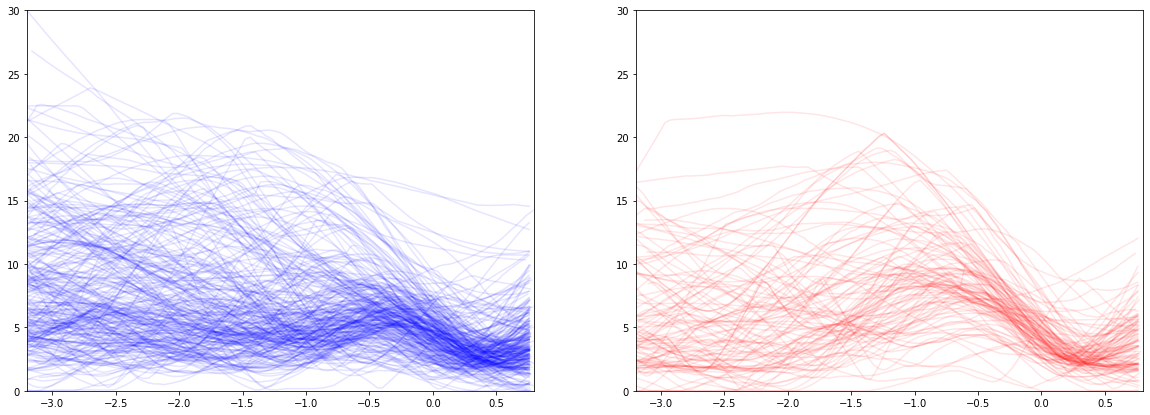

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))
df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax2.plot(Time,T,'b-',alpha=0.1)
    k+=1
    
for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))

(0, 2)

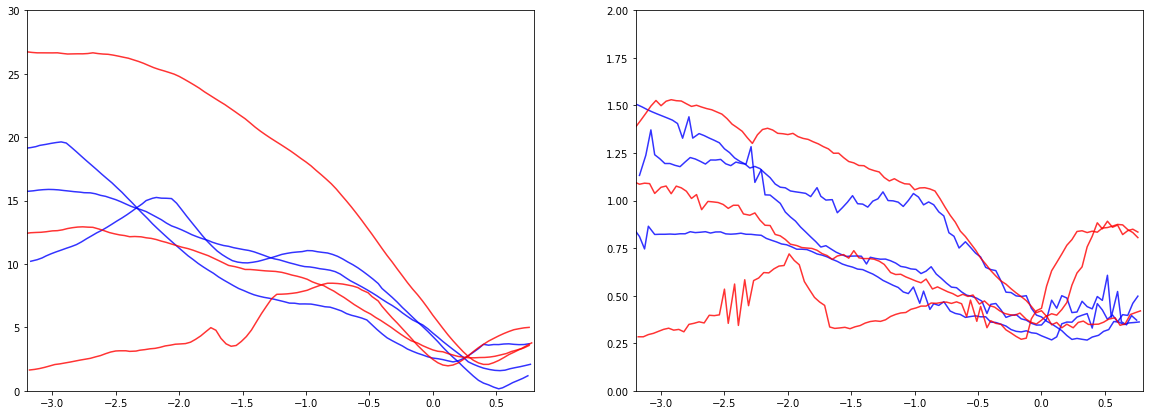

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,7))
k=0
for row in df_curry_pull_up.iloc[:3].itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    tts=getattr(row,'Time_to_shoot')
    ax1.axvline(tts, color='b',linestyle="dashed",lw=0.5)
    ax2.axvline(tts, color='b',linestyle="dashed",lw=0.5)
    ax1.plot(Time,D,'b-',alpha=0.8)
    ax2.plot(Time,T,'b-',alpha=0.8)
    k+=1
    
for row in df_curry_catch.iloc[:3].itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    tts=getattr(row,'Time_to_shoot')
    ax1.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax2.axvline(tts, color='black',linestyle="dashed",lw=0.5)
    ax1.plot(Time,D,'r-',alpha=0.8)
    ax2.plot(Time,T,'r-',alpha=0.8)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,2))

### Comparing two players with hign percentage

(0, 30)

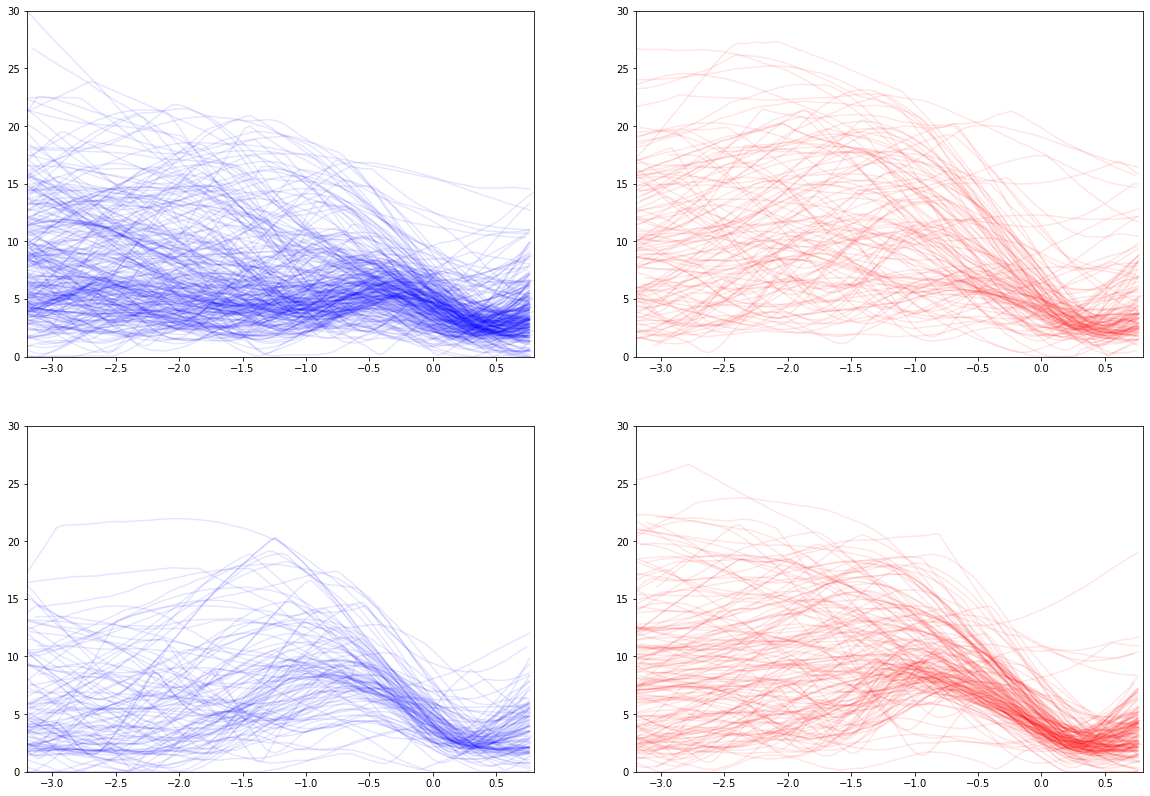

In [22]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(20,14))
df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_other_pull_up=df_shots.query('player_id==202691 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
df_other_catch=df_shots.query('player_id==202691 and Shot_type=="catch-and-shoot 3P"').copy()
for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)

for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax3.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)
    
for row in df_other_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
for row in df_other_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax4.plot(Time,D,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))
ax3.set_xlim((-3.2,0.8))
ax3.set_ylim((0,30))
ax4.set_xlim((-3.2,0.8))
ax4.set_ylim((0,30))

### Comparing two players : one with high and the other with low percentage

number of shots Curry: 390
percentage of CandS Curry: 0.2794871794871795
number of shots Other: 56
percentage of CandS Other: 0.35714285714285715


(0, 30)

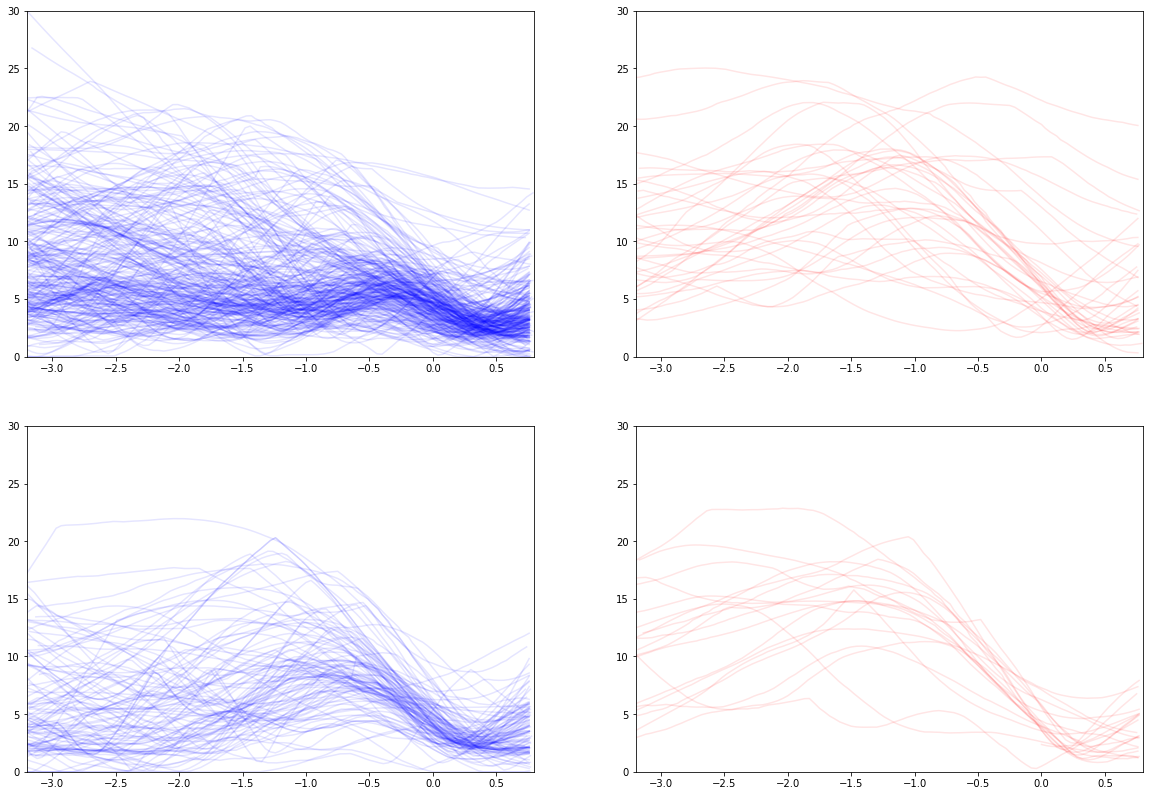

In [27]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(20,14))
df_curry_pull_up=df_shots.query('player_id==201939 and Shot_type=="pull-up 3P"').copy()
df_other_pull_up=df_shots.query('player_id==202323 and Shot_type=="pull-up 3P"').copy()
df_curry_catch=df_shots.query('player_id==201939 and Shot_type=="catch-and-shoot 3P"').copy()
df_other_catch=df_shots.query('player_id==202323 and Shot_type=="catch-and-shoot 3P"').copy()

print('number of shots Curry:',len(df_curry_pull_up)+len(df_curry_catch))
print('percentage of CandS Curry:',len(df_curry_catch)/(len(df_curry_catch)+len(df_curry_pull_up)))
print('number of shots Other:',len(df_other_pull_up)+len(df_other_catch))
print('percentage of CandS Other:',len(df_other_catch)/(len(df_other_catch)+len(df_other_pull_up)))

for row in df_curry_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax1.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)

for row in df_curry_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax3.plot(Time,D,'b-',alpha=0.1)
    #ax3.plot(Time,T,'b-',alpha=0.1)
    
for row in df_other_pull_up.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax2.plot(Time,D,'r-',alpha=0.1)
    #ax2.plot(Time,T,'r-',alpha=0.1)
    
for row in df_other_catch.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    T=getattr(row,'T')
    ax4.plot(Time,D,'r-',alpha=0.1)
    
ax1.set_xlim((-3.2,0.8))
ax1.set_ylim((0,30))
ax2.set_xlim((-3.2,0.8))
ax2.set_ylim((0,30))
ax3.set_xlim((-3.2,0.8))
ax3.set_ylim((0,30))
ax4.set_xlim((-3.2,0.8))
ax4.set_ylim((0,30))

## *Free space* and 3P performance
------

We want to quantify the following intuition : "the more free a shooter is, the more efficient he is". To do so, we evaluate 3-point efficiency function of the distance (and time) within the opponent defender is. The code is available in python-file/statistics.py.

![](images/efficiency_inferior_d_bis.png)
*Shot efficiency as a function of maximum available space $\delta_{space}^*$ at the release-time of the ball. If the closest defender is within 4 feet, the shooting percentage is 26,3\%, while it goes to 33,6\% if he is within 8 feet.*

![](images/efficiency_inferior_t_bis.png)
*Shot efficiency as a function of maximum available time $\delta_{time}^*$ (free space) at the release of the ball. Around $t=0.5s$ a significant change in behaviour is observed.*


## Classifying players
---

In [9]:
def structure_data_by_shot(data):
    
    ### getting the data ###
    D_CLOSEST_PLAYER=data['D_CLOSEST_DEF']
    T_CLOSEST_PLAYER=data['T_CLOSEST_DEF']
    TIME=data['TIME_ABSCISSE']
    TIME_TO_SHOOT=data['TIME_TO_SHOOT']
    WHO_SHOT=data['WHO_SHOT']
    POSITION_SHOT=data['POSTION_SHOT']
    BALL_TRAJECTORIES=data['BALL_TRAJECTORIES']
    TIME_SHOTS=data['TIME_SHOTS']
    MATCH_ID=data['MATCH_ID']
    
    ### only the second column because the first one contains if it is a succes or a miss ###
    D_CLOSEST_PLAYER_bis=[]
    T_CLOSEST_PLAYER_bis=[]
    TIME_bis=[]
    TIME_TO_SHOOT_bis=[]
    WHO_SHOT_bis=[]
    X_SHOT=[]
    Y_SHOT=[]
    X_BALL=[]
    Y_BALL=[]
    Z_BALL=[]
    QUARTER=[]
    CLOCK=[]
    MATCH_ID_bis=[]
    SUCCESS=[]
    SHOT_ID=[]
    nb_catch_and_shoot=0
    nb_pull_up=0
    nb_success=0
    nb_missed=0
    nb_cns_success=0
    nb_cns_missed=0
    nb_pull_up_success=0
    nb_pull_up_missed=0
    for k in range(len(D_CLOSEST_PLAYER)):
        unique,count=np.unique(np.array(TIME[k][1]).round(2), return_counts=True)
        if list(count)==[1]*len(count): # we don't take shots where values of time are repeated, because in the data, sometimes the values of time doesn't change so stay on the same second but we count the evolution on this second
            if D_CLOSEST_PLAYER[k][0]==0:
                nb_missed+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_missed+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_missed+=1
            else :
                nb_success+=1
                if TIME_TO_SHOOT[k][1]>-2:
                    nb_catch_and_shoot+=1
                    nb_cns_success+=1
                else :
                    nb_pull_up+=1
                    nb_pull_up_success+=1
            D_CLOSEST_PLAYER_bis.append(D_CLOSEST_PLAYER[k][1])
            T_CLOSEST_PLAYER_bis.append(T_CLOSEST_PLAYER[k][1])
            TIME_bis.append(np.array(TIME[k][1]).round(2)) # round to 0.01 second
            TIME_TO_SHOOT_bis.append([TIME_TO_SHOOT[k][1]]*len(TIME[k][1]))
            SUCCESS.append(TIME_TO_SHOOT[k][0])
            WHO_SHOT_bis.append(WHO_SHOT[k])
            X_SHOT.append(POSITION_SHOT[k][0])
            Y_SHOT.append(POSITION_SHOT[k][1])
            X_BALL.append(np.array(BALL_TRAJECTORIES[k][0]))
            Y_BALL.append(np.array(BALL_TRAJECTORIES[k][1]))
            Z_BALL.append(np.array(BALL_TRAJECTORIES[k][2]))
            QUARTER.append(5-TIME_SHOTS[k][0])
            CLOCK.append(TIME_SHOTS[k][1])
            MATCH_ID_bis.append(MATCH_ID[k])
            SHOT_ID.append(k)
    
    print('number of valid shot:',len(D_CLOSEST_PLAYER_bis))
    print('number of success :',nb_success)
    print('number of miss :',nb_missed)
    print('percentage of success:',nb_success/(nb_success+nb_missed)*100)
    print('percentage of catch-and-shoot shots :',nb_catch_and_shoot/(nb_pull_up+nb_catch_and_shoot)*100)
    print('percentage of catch-and-shoot success:',nb_cns_success/(nb_cns_missed+nb_cns_success)*100)
    print('percentage of pull-up success:',nb_pull_up_success/(nb_pull_up_missed+nb_pull_up_success)*100)

    
    ### put the data into a dataframe ###
    df=pd.DataFrame({'D':D_CLOSEST_PLAYER_bis,'T':T_CLOSEST_PLAYER_bis,'Time':TIME_bis,'Time_to_shoot':TIME_TO_SHOOT_bis,'Shot result':SUCCESS,'player_id':WHO_SHOT_bis,'x_ball':X_BALL,'y_ball':Y_BALL,'z_ball':Z_BALL,'x_shooter':X_SHOT,'y_shooter':Y_SHOT,'quarter':QUARTER,'clock':CLOCK,'Match_id':MATCH_ID_bis,'shot_id':SHOT_ID})
    
    return(df)

In [10]:
df_shots=structure_data_by_shot(dico)

number of valid shot: 27477
number of success : 9546
number of miss : 17931
percentage of success: 34.74178403755869
percentage of catch-and-shoot shots : 78.7531389889726
percentage of catch-and-shoot success: 35.902768150099355
percentage of pull-up success: 30.438506337786915


(0, 30)

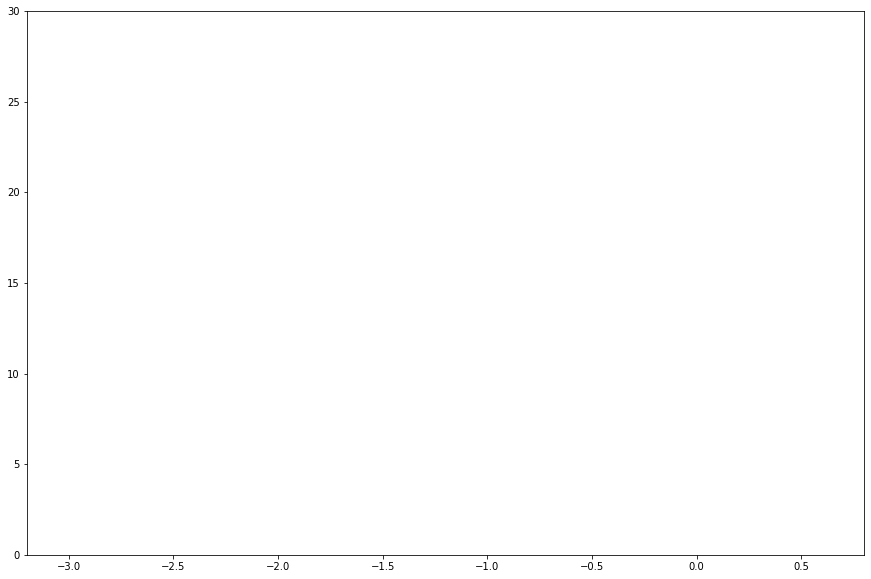

In [17]:
fig=plt.figure(figsize=(15,10))
for row in df_shots.itertuples():
    Time=getattr(row,'Time')
    D=getattr(row,'D')
    plt.plot(Time,D,'k-',alpha=0.0008)
plt.xlim((-3.2,0.8))
plt.ylim((0,30))

In [126]:
df_shots.head(10)

,D,T,Time,Time_to_shoot,Shot result,player_id,x_ball,y_ball,z_ball,x_shooter,y_shooter,quarter,clock,Match_id,shot_id
0,"[11.587928617820356, 11.517308766135429, 11.44...","[0.8479570300396599, 0.8277184735272738, 0.824...","[-3.19, -3.15, -3.11, -3.07, -3.03, -2.99, -2....","[-1.0400000000000205, -1.0400000000000205, -1....",1,101141,"[14.90401, 14.58483, 14.25015, 13.93685, 13.62...","[13.17573, 13.18753, 13.17741, 13.15654, 13.20...","[3.44914, 3.59095, 3.65601, 3.72263, 3.49907, ...",29.52828,20.32265,1,410.57,001,0
1,"[11.89748295465894, 12.028642344408615, 12.169...","[0.9647198269996493, 0.9733393130803043, 0.986...","[-3.22, -3.18, -3.14, -3.1, -3.06, -3.02, -2.9...","[-1.4099999999999682, -1.4099999999999682, -1....",0,200757,"[83.23076, 83.05729, 82.60646, 82.28482, 81.97...","[8.22222, 8.55749, 9.03977, 9.67574, 10.41964,...","[2.33123, 2.57507, 2.97214, 3.31004, 3.51796, ...",88.38452,46.75445,1,367.54,001,1
2,"[11.234452252054838, 11.431016833462369, 11.70...","[1.1138791162330979, 1.1252081128990592, 1.125...","[-3.22, -3.18, -3.14, -3.1, -3.06, -3.02, -2.9...","[-0.4800000000000182, -0.4800000000000182, -0....",1,203484,"[42.26991, 41.85248, 41.02347, 40.72615, 40.46...","[7.85332, 8.10254, 8.07781, 7.94997, 8.12103, ...","[1.75873, 0.59416, 0.69868, 1.32614, 1.98342, ...",12.77934,47.70005,1,359.00,001,2
3,"[2.4600896391188685, 2.718964593609118, 3.0004...","[0.6037057729934399, 0.625034479849829, 0.6405...","[-3.21, -3.17, -3.13, -3.09, -3.05, -3.01, -2....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0,202694,"[27.20299, 27.30175, 27.39426, 27.19086, 27.28...","[40.29969, 39.83017, 39.23873, 38.51537, 37.68...","[2.61371, 2.92557, 3.26916, 3.40316, 3.60503, ...",19.34511,45.32964,1,169.94,001,3
4,"[3.0487653593709045, 2.883303347793985, 2.7179...","[0.4300673466955519, 0.4348024982077016, 0.436...","[-3.21, -3.16, -3.12, -3.08, -3.04, -3.0, -2.9...","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0,200794,"[53.99945, 54.65922, 55.09244, 55.58923, 56.08...","[11.73886, 11.59605, 11.51835, 11.4199, 11.062...","[2.41028, 2.54081, 2.3885, 2.02862, 1.80495, 1...",89.92384,2.43190,1,132.47,001,4
5,"[18.881588606610944, 18.953068724979598, 19.00...","[1.3402907380276396, 1.3169575416935888, 1.284...","[-3.31, -3.27, -3.23, -3.19, -3.14, -3.1, -3.0...","[-2.480000000000018, -2.480000000000018, -2.48...",1,201143,"[83.574, 83.60444, 83.633, 83.65922, 83.68265,...","[2.89537, 2.8942, 2.89304, 2.89193, 2.89091, 2...","[3.33412, 3.54434, 3.76978, 4.00846, 4.25836, ...",64.83893,18.59967,2,631.99,001,5
6,"[16.018103103982074, 16.123509585152362, 16.23...","[1.106729995444518, 1.0934980084313428, 1.0841...","[-3.14, -3.1, -3.06, -3.02, -2.98, -2.94, -2.9...","[-0.9800000000000182, -0.9800000000000182, -0....",0,101141,"[42.21514, 41.96621, 41.76056, 41.41828, 41.04...","[34.19802, 34.98229, 35.92356, 36.1373, 36.307...","[3.00041, 3.52176, 4.04311, 4.01742, 3.94148, ...",29.03670,18.40283,2,564.60,001,7
7,"[11.732238364493792, 11.760223781157396, 11.77...","[0.6848464004980791, 0.6889242222818717, 0.731...","[-3.18, -3.14, -3.1, -3.06, -3.02, -2.98, -2.9...","[-2.1499999999999773, -2.1499999999999773, -2....",1,1626169,"[29.35667, 28.80373, 27.72601, 26.99513, 26.81...","[22.48396, 22.49057, 22.50285, 22.50946, 22.22...","[3.61467, 3.01912, 1.91308, 1.31752, 2.54811, ...",4.12706,1.89300,2,530.66,001,8
8,"[15.235505696382384, 15.189015969081078, 15.13...","[0.9695488247676792, 0.9633934274394031, 0.959...","[-3.36, -3.32, -3.28, -3.24, -3.2, -3.15, -3.1...","[-0.9599999999999795, -0.9599999999999795, -0....",0,2581,"[10.79175, 10.93025, 11.23015, 11.55541, 11.95...","[38.4586, 38.44904, 38.57119, 38.7701, 38.9387...","[7.62343, 7.46493, 7.43386, 7.40553, 6.98783, ...",25.71071,10.49196,2,472.24,001,9
9,"[4.310246196819852, 4.344212253976549, 4.36388...","[0.668938923159119, 0.6329368332275428, 0.6089...","[-3.2, -3.17, -3.13, -3.08, -3.05, -3.0, -2.96...","[-1.0399999999999636, -1.0399999999999636, -1....",1,10

In [23]:
def players_stats(df_shots):
    df1=df_shots[['player_id','Shot result','D','Match_id']].groupby(['player_id','Match_id']).count()
    df2=df_shots[['player_id','Shot result','D','Match_id']].groupby(['player_id','Shot result']).count()
    players_id=df_shots['player_id'].unique()
    
    total=[]
    success=[]
    miss=[]
    percentage=[]
    match_played=[]
    
    for player in players_id:
        match_played.append(len(df1.loc[player]))
        if 1 in df2.loc[player,'D'].index:
            s=df2.loc[(player,1),'D']
        else :
            s=0
        if 0 in df2.loc[player,'D'].index:
            m=df2.loc[(player,0),'D']
        else :
            m=0
        total.append(m+s)
        success.append(s)
        miss.append(m)
        percentage.append(round(s/(m+s)*100,1))
    
    df_stats=pd.DataFrame({'total':total,'success':success,'miss':miss,'percentage':percentage,'match_played':match_played},index=players_id)
    return df_stats
                          
df_stats=players_stats(df_shots)

In [25]:
df_stats.query('total>50').sort_values('success',ascending=True).head(20)

,total,success,miss,percentage,match_played
202323,56,6,50,10.7,30
201196,56,14,42,25.0,26
202708,57,15,42,26.3,20
200757,62,15,47,24.2,32
203507,51,15,36,29.4,22
2746,51,15,36,29.4,23
203460,55,16,39,29.1,32
203935,77,16,61,20.8,22
203924,68,16,52,23.5,33
203096,64,16,48,25.0,28


In [104]:
id_inf_25=df_stats.query('total>50 and percentage<25').index
id_25_30=df_stats.query('total>50 and 25<=percentage<30').index
id_30_35=df_stats.query('total>50 and 30<=percentage<35').index
id_35_40=df_stats.query('total>50 and 35<=percentage<40').index
id_sup_40=df_stats.query('total>50 and percentage>=40').index

def players_accuracy(row):
    if row['player_id'] in id_inf_25 :
        return('inf_25')
    if row['player_id'] in id_25_30 :
        return('25_30')
    if row['player_id'] in id_30_35 :
        return('30_35')
    if row['player_id'] in id_35_40 :
        return('35_40')
    if row['player_id'] in id_sup_40 :
        return('sup_40')
    return ('not enough shots')

df_plot_players=df.copy()
df_plot_players['player_accuracy']=df.apply(players_accuracy,axis=1)

In [113]:
df_plot_players=df_plot_players.query('player_accuracy!="not enough shots"')

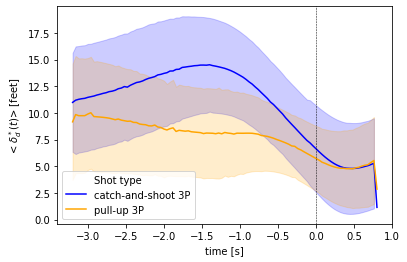

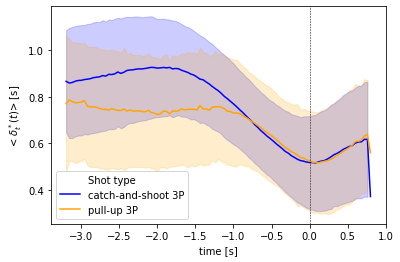

<Figure size 432x288 with 0 Axes>

In [121]:
averaged_evolution(df_plot_players.query('player_accuracy=="inf_25"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

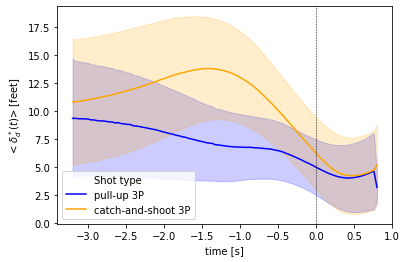

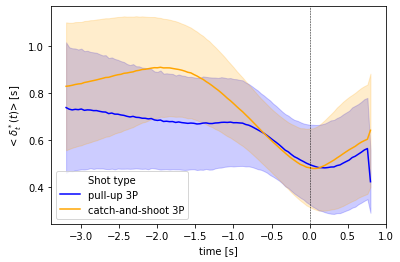

<Figure size 432x288 with 0 Axes>

In [122]:
averaged_evolution(df_plot_players.query('player_accuracy=="25_30"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

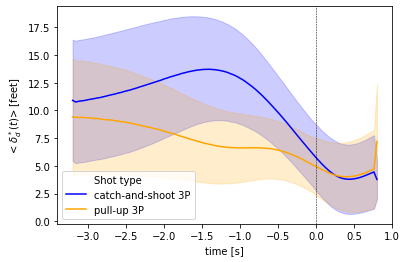

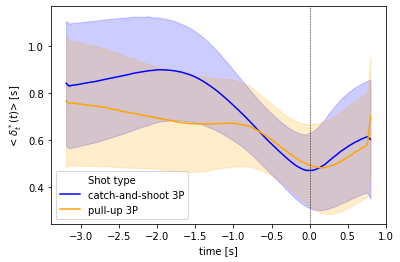

<Figure size 432x288 with 0 Axes>

In [123]:
averaged_evolution(df_plot_players.query('player_accuracy=="30_35"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

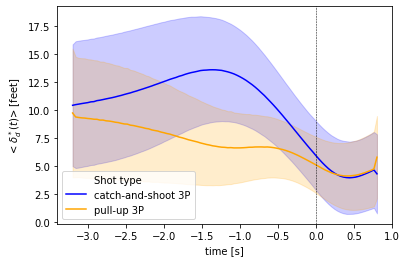

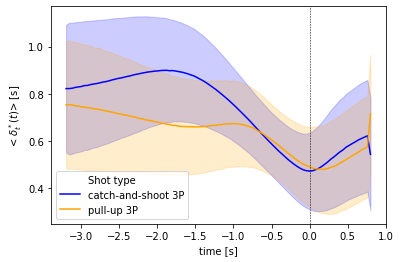

<Figure size 432x288 with 0 Axes>

In [124]:
averaged_evolution(df_plot_players.query('player_accuracy=="35_40"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

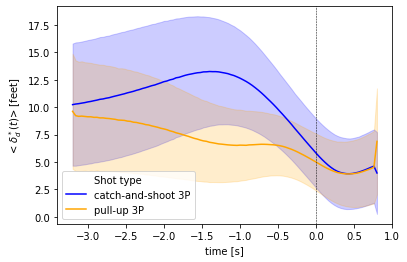

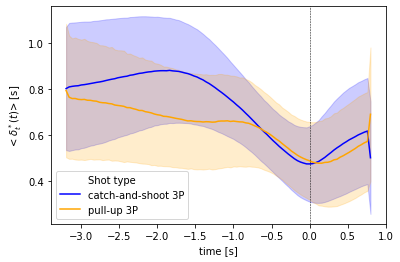

<Figure size 432x288 with 0 Axes>

In [125]:
averaged_evolution(df_plot_players.query('player_accuracy=="sup_40"'),hue='Shot type',palette=['blue','orange'],fontsize='medium',sd='sd')

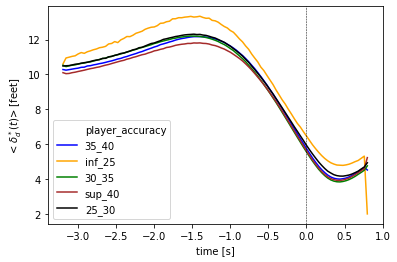

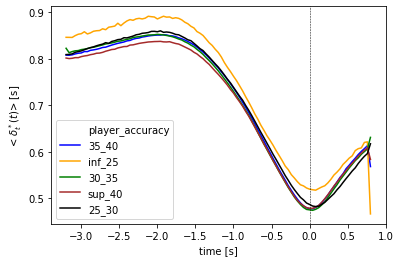

<Figure size 432x288 with 0 Axes>

In [119]:
averaged_evolution(df_plot_players,hue='player_accuracy',palette=['blue','orange','green','brown','black'],fontsize='medium')

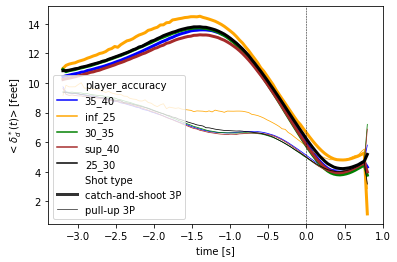

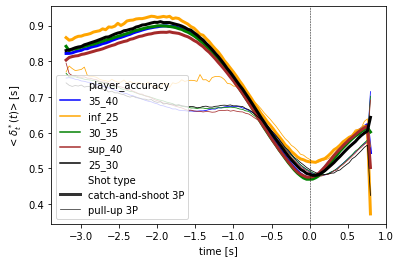

<Figure size 432x288 with 0 Axes>

In [118]:
averaged_evolution(df_plot_players,hue='player_accuracy',palette=['blue','orange','green','brown','black'],fontsize='medium',size='Shot type')

## Trying to classify shots ( _not running_ )
----